In [1]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt

2023-05-21 11:52:44.170351: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Base parameters for the NN 
GESTURES = [
    "left_15",
    "up_15",
    "front_15"
]
NUM_GESTURES = len(GESTURES)

In [4]:
df= pd.read_csv('data/left_15.csv', sep=',',names=["FechaHora", "NumPaquete", "IdClient", "ax","ay","az","gx","gy","gz","angX","angY","Actividad"])  
df

,FechaHora,NumPaquete,IdClient,ax,ay,az,gx,gy,gz,angX,angY,Actividad
0,Sat May 13 16:32:58 2023,0.0,0.0,-7492.0,764.0,1962.0,-503.0,-1620.0,197.0,1.80,1.80,2
1,Sat May 13 16:32:58 2023,1.0,0.0,-7452.0,712.0,2384.0,-656.0,265.0,-407.0,3.57,3.57,2
2,Sat May 13 16:32:58 2023,2.0,0.0,-7960.0,698.0,2370.0,120.0,528.0,-5.0,5.30,5.30,2
3,Sat May 13 16:32:58 2023,6.0,0.0,-7608.0,586.0,1950.0,-101.0,81.0,-55.0,11.87,11.87,2
4,Sat May 13 16:32:58 2023,8.0,0.0,-7846.0,532.0,1890.0,338.0,477.0,-34.0,14.97,14.97,2
...,...,...,...,...,...,...,...,...,...,...,...,...
237,Sat May 13 16:33:28 2023,266.0,0.0,-8070.0,1080.0,-958.0,207.0,-233.0,377.0,50.49,88.15,2
238,Sat May 13 16:33:28 2023,267.0,0.0,-8138.0,1344.0,-1012.0,-125.0,579.0,344.0,51.28,88.19,2
239,Sat May 13 16:33:29 2023,268.0,0.0,-7698.0,1182.0,-664.0,-133.0,353.0,-144.0,52.05,88.23,2
240,Sat May 13 16:33:29 2023,269.0,0.0,-8196.0,1280.0,-752.0,-178.0,50.0,-50.0,52.81,88.26,2


In [5]:
df.max()

FechaHora     Sat May 13 16:33:29 2023
NumPaquete                       270.0
IdClient                           0.0
ax                              1362.0
ay                              3188.0
az                             19690.0
gx                             32767.0
gy                             14793.0
gz                              5617.0
angX                             53.56
angY                              88.3
Actividad                            2
dtype: object

## Transformation to G and m/s²

In [6]:
for i in range(NUM_GESTURES):
    df= pd.read_csv(f'data/{GESTURES[i]}.csv', sep=',',names=["FechaHora", "NumPaquete", "IdClient", "ax","ay","az","gx","gy","gz","angX","angY","Actividad"])  
    # The acelerometer goes between -4g and +4g and the equivalent LSB is 8192
    df['ax']= df['ax']/8192
    df['ay']= df['ay']/8192
    df['az']= df['az']/8192


    # The gyroscope goes between -500 and 500 and the equivalent LSB is 65.5
    df['gx']= df['gx']/65.5
    df['gy']= df['gy']/65.5
    df['gz']= df['gz']/65.5
    df.max()

### Finding the accurate sample rate

/tmp/ipykernel_3971/36449399.py:7: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "g." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['ax'], 'g.', label='x', linestyle='solid', marker=',')
/tmp/ipykernel_3971/36449399.py:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "b." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['ay'], 'b.', label='y', linestyle='solid', marker=',')
/tmp/ipykernel_3971/36449399.py:9: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "r." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['az'], 'r.', label='z', linestyle='solid', marker=',')


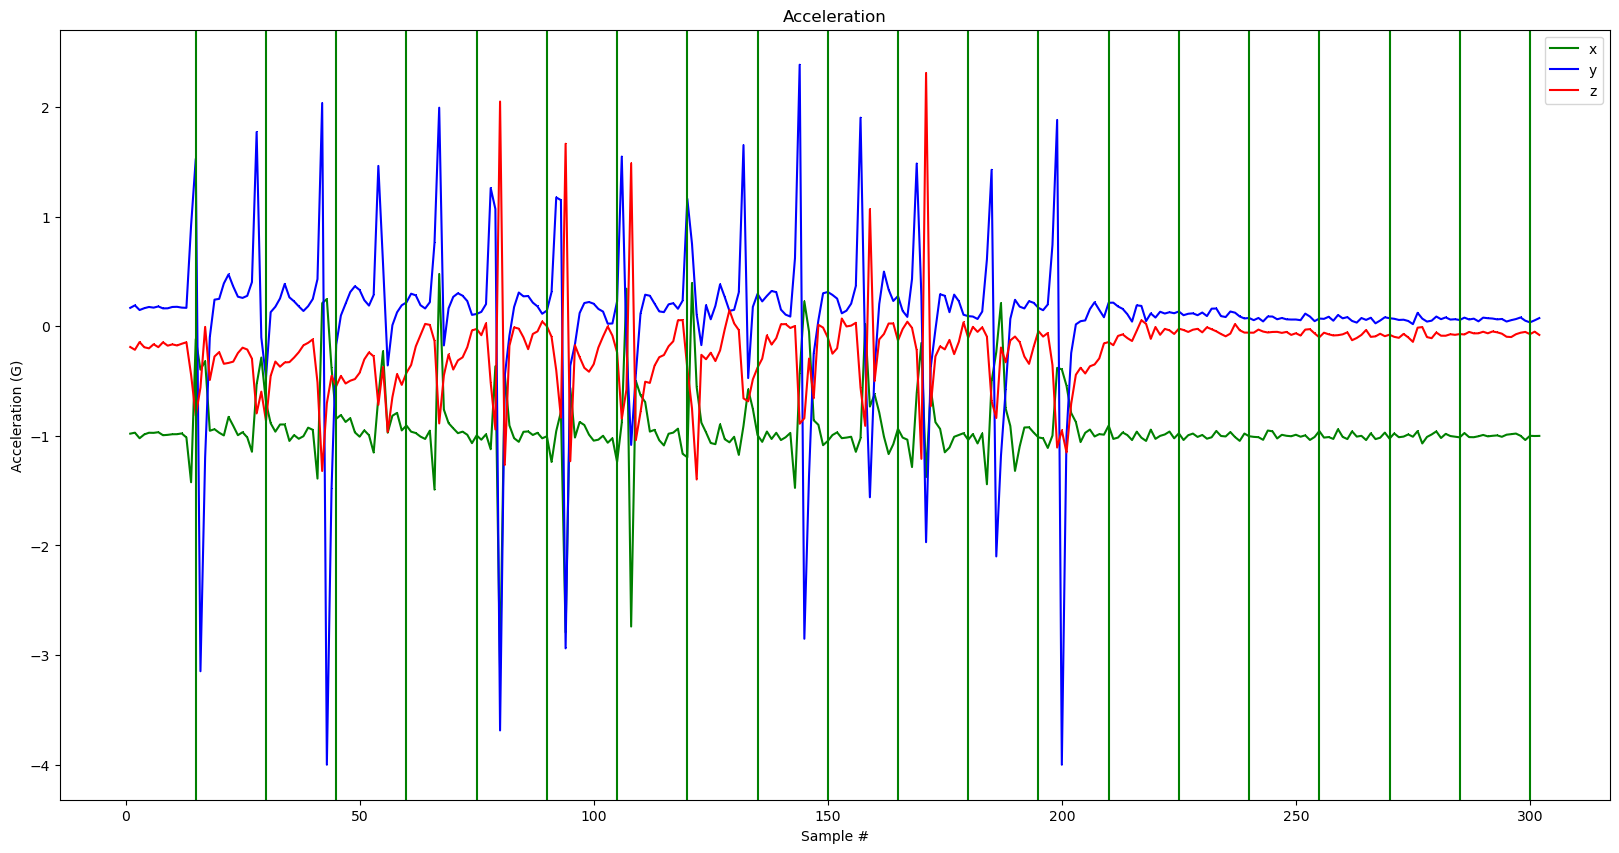

/tmp/ipykernel_3971/36449399.py:22: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "g." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['gx'], 'g.', label='x', linestyle='solid', marker=',')
/tmp/ipykernel_3971/36449399.py:23: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "b." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['gy'], 'b.', label='y', linestyle='solid', marker=',')
/tmp/ipykernel_3971/36449399.py:24: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "r." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['gz'], 'r.', label='z', linestyle='solid', marker=',')


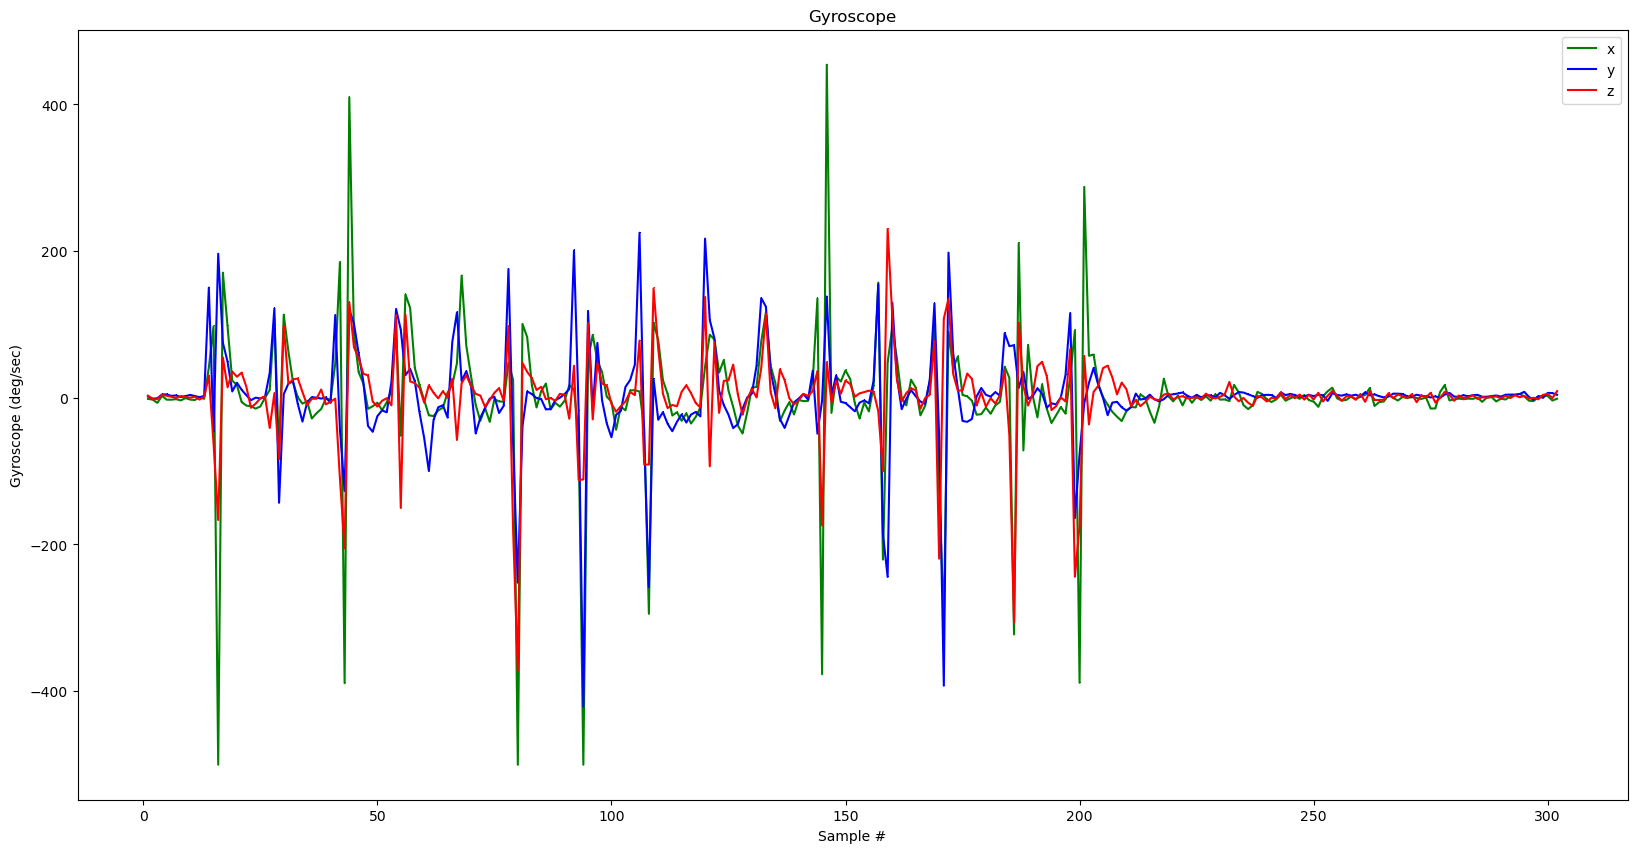

In [7]:
index = range(1, len(df['ax']) + 1)
NUM_SAMPLES=15


plt.rcParams["figure.figsize"] = (20,10)

plt.plot(index, df['ax'], 'g.', label='x', linestyle='solid', marker=',')
plt.plot(index, df['ay'], 'b.', label='y', linestyle='solid', marker=',')
plt.plot(index, df['az'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Acceleration")
plt.xlabel("Sample #")
plt.ylabel("Acceleration (G)")
#plt.axvline(x = 25, color = 'b', label = 'axvline - full height')
for i in range(1, len(df['ax']) + 1): 
    if i%NUM_SAMPLES ==0:
        plt.axvline(x = i, color = 'g')

plt.legend()
plt.show()


plt.plot(index, df['gx'], 'g.', label='x', linestyle='solid', marker=',')
plt.plot(index, df['gy'], 'b.', label='y', linestyle='solid', marker=',')
plt.plot(index, df['gz'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Gyroscope")
plt.xlabel("Sample #")
plt.ylabel("Gyroscope (deg/sec)")
plt.legend()
plt.show()



## Normalizing data from -1 to 1 

In [8]:
# Base parameters for the NN 
GESTURES = [
    "left_15",
    "up_15",
    "front_15"
]
NUM_GESTURES = len(GESTURES)
for i in range(NUM_GESTURES):
    df= pd.read_csv(f'data/{GESTURES[i]}.csv', sep=',',names=["FechaHora", "NumPaquete", "IdClient", "ax","ay","az","gx","gy","gz","angX","angY","Actividad"]) 
   #After scalating the values we normalize
    #Aceleromter
    df['ax']=(df['ax'] - df['ax'].min()) / (df['ax'].max() - df['ax'].min())
    df['ay']=(df['ay'] - df['ay'].min()) / (df['ay'].max() - df['ay'].min())
    df['az']=(df['az'] - df['az'].min()) / (df['az'].max() - df['az'].min())
    #Gyroscope
    df['gx']=(df['gx'] - df['gx'].min()) / (df['gx'].max() - df['gx'].min())
    df['gy']=(df['gy'] - df['gy'].min()) / (df['gy'].max() - df['gy'].min())
    df['gz']=(df['gz'] - df['gz'].min()) / (df['gz'].max() - df['gz'].min())
    print(df)

    

                    FechaHora  NumPaquete  IdClient        ax        ay  \
0    Sat May 13 16:32:58 2023         0.0       0.0  0.569190  0.895706   
1    Sat May 13 16:32:58 2023         1.0       0.0  0.571137  0.893469   
2    Sat May 13 16:32:58 2023         2.0       0.0  0.546419  0.892866   
3    Sat May 13 16:32:58 2023         6.0       0.0  0.563546  0.888048   
4    Sat May 13 16:32:58 2023         8.0       0.0  0.551966  0.885724   
..                        ...         ...       ...       ...       ...   
237  Sat May 13 16:33:28 2023       266.0       0.0  0.541067  0.909302   
238  Sat May 13 16:33:28 2023       267.0       0.0  0.537758  0.920661   
239  Sat May 13 16:33:29 2023       268.0       0.0  0.559167  0.913691   
240  Sat May 13 16:33:29 2023       269.0       0.0  0.534936  0.917907   
241  Sat May 13 16:33:29 2023       270.0       0.0  0.524231  0.913260   

           az        gx        gy        gz   angX   angY  Actividad  
0    0.637849  0.383386  0.4

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

print(f"TensorFlow version = {tf.__version__}\n")

# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

# the list of gestures that data is available for
GESTURES = [
    "left_15",
    "up_15",
    "front_15"
]

SAMPLES_PER_GESTURE = 15

NUM_GESTURES = len(GESTURES)

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)
print(ONE_HOT_ENCODED_GESTURES)

inputs = []
outputs = []

# read each csv file and push an input and output
for gesture_index in range(NUM_GESTURES):
    gesture = GESTURES[gesture_index]
    print(f"Processing index {gesture_index} for gesture '{gesture}'.")

    output = ONE_HOT_ENCODED_GESTURES[gesture_index]
    df= pd.read_csv(f'data/{GESTURES[gesture_index]}.csv', sep=',',names=["FechaHora", "NumPaquete", "IdClient", "ax","ay","az","gx","gy","gz","angX","angY","Actividad"]) 

       #After scalating the values we normalize
    #Aceleromter
    df['ax']=(df['ax'] - df['ax'].min()) / (df['ax'].max() - df['ax'].min())
    df['ay']=(df['ay'] - df['ay'].min()) / (df['ay'].max() - df['ay'].min())
    df['az']=(df['az'] - df['az'].min()) / (df['az'].max() - df['az'].min())
    #Gyroscope
    df['gx']=(df['gx'] - df['gx'].min()) / (df['gx'].max() - df['gx'].min())
    df['gy']=(df['gy'] - df['gy'].min()) / (df['gy'].max() - df['gy'].min())
    df['gz']=(df['gz'] - df['gz'].min()) / (df['gz'].max() - df['gz'].min())


    # calculate the number of gesture recordings in the file
    num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)

    print(f"\tThere are {num_recordings} recordings of the {gesture} gesture.")

    for i in range(num_recordings):
        #print(f"{i} value of i")
        tensor = []
        for j in range(SAMPLES_PER_GESTURE):
            index = i * SAMPLES_PER_GESTURE + j

            # normalize the input data, between 0 to 1:
            # - acceleration is between: -4 to +4
            # - gyroscope is between: -2000 to +2000
            tensor += [
            df['ax'][index],
            df['ay'][index],
            df['az'][index],
            df['gx'][index],
            df['gy'][index],
            df['gz'][index] ]

        inputs.append(tensor)
        outputs.append(output)
        print(outputs)

# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)


print("Data set parsing and preparation complete.")

TensorFlow version = 2.12.0

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Processing index 0 for gesture 'left_15'.
	There are 16 recordings of the left_15 gesture.
[array([1., 0., 0.])]
[array([1., 0., 0.]), array([1., 0., 0.])]
[array([1., 0., 0.]), array([1., 0., 0.]), array([1., 0., 0.])]
[array([1., 0., 0.]), array([1., 0., 0.]), array([1., 0., 0.]), array([1., 0., 0.])]
[array([1., 0., 0.]), array([1., 0., 0.]), array([1., 0., 0.]), array([1., 0., 0.]), array([1., 0., 0.])]
[array([1., 0., 0.]), array([1., 0., 0.]), array([1., 0., 0.]), array([1., 0., 0.]), array([1., 0., 0.]), array([1., 0., 0.])]
[array([1., 0., 0.]), array([1., 0., 0.]), array([1., 0., 0.]), array([1., 0., 0.]), array([1., 0., 0.]), array([1., 0., 0.]), array([1., 0., 0.])]
[array([1., 0., 0.]), array([1., 0., 0.]), array([1., 0., 0.]), array([1., 0., 0.]), array([1., 0., 0.]), array([1., 0., 0.]), array([1., 0., 0.]), array([1., 0., 0.])]
[array([1., 0., 0.]), array([1., 0., 0.]), array([1., 0., 0.]), array([1., 0., 

In [10]:
print(inputs)

[[0.56919035 0.89570605 0.63784932 ... 0.22568389 0.50150817 0.66029353]
 [0.56831452 0.94139919 0.57174375 ... 0.24299429 0.60366601 0.67097644]
 [0.5509926  0.9109371  0.55041673 ... 0.1856142  0.47290265 0.6170627 ]
 ...
 [0.58575591 0.63696143 0.36100323 ... 0.52382628 0.65479931 0.61788021]
 [0.59632717 0.63707612 0.35086564 ... 0.52456211 0.65801224 0.61547423]
 [0.59727587 0.63872004 0.35665855 ... 0.52688155 0.66214652 0.6270989 ]]


## Splitting train and test data

In [11]:
# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
# https://stackoverflow.com/a/37710486/2020087
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

print(TRAIN_SPLIT)
print(TEST_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")

30
40
Data set randomization and splitting complete.


In [35]:
print(inputs_validate)

[[0.59727587 0.63872004 0.35665855 0.51840358 0.6539252  0.61934912
  0.58697567 0.63604389 0.36297808 0.52443414 0.65404333 0.61846271
  0.58670461 0.63722904 0.35935751 0.52528193 0.6552718  0.62013423
  0.58914413 0.63340597 0.359555   0.51893146 0.65664202 0.62107129
  0.59246459 0.63868181 0.36337305 0.52283452 0.65432682 0.6170951
  0.58887308 0.63787896 0.359555   0.52174678 0.65822486 0.62266684
  0.59029613 0.63742019 0.36403133 0.52646565 0.65857922 0.61752564
  0.5913126  0.63619681 0.36192482 0.52782532 0.6585556  0.62390781
  0.58778885 0.63677027 0.3586334  0.52955291 0.65968957 0.61929847
  0.59307447 0.63313836 0.35106313 0.5262417  0.66439084 0.6223376
  0.59442976 0.63508812 0.35033902 0.5200032  0.65349996 0.61615803
  0.59592058 0.63665558 0.357251   0.5196033  0.64747573 0.61805749
  0.59029613 0.63894942 0.36100323 0.5254099  0.65541355 0.61461314
  0.57965711 0.63432351 0.36297808 0.52747341 0.65165726 0.6246676
  0.59022837 0.63195321 0.35744849 0.52688155 0.662

## Building neural network model and training

In [12]:
# build the model and train it
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation='relu')) # relu is used for performance
model.add(tf.keras.layers.Dense(15, activation='relu'))
model.add(tf.keras.layers.Dense(NUM_GESTURES, activation='softmax')) # softmax is used, because we only expect one gesture to occur per input
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(inputs_train, outputs_train, epochs=600, batch_size=1, validation_data=(inputs_validate, outputs_validate))

Epoch 1/600


2023-05-21 12:02:40.786767: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


30/30 [==============================] - 0s 4ms/step - loss: 0.2016 - mae: 0.4085 - val_loss: 0.2179 - val_mae: 0.4243
Epoch 2/600
30/30 [==============================] - 0s 1ms/step - loss: 0.1570 - mae: 0.3559 - val_loss: 0.2177 - val_mae: 0.4122
Epoch 3/600
30/30 [==============================] - 0s 1ms/step - loss: 0.1384 - mae: 0.3249 - val_loss: 0.1970 - val_mae: 0.3879
Epoch 4/600
30/30 [==============================] - 0s 1ms/step - loss: 0.1191 - mae: 0.2946 - val_loss: 0.1792 - val_mae: 0.3630
Epoch 5/600
30/30 [==============================] - 0s 1ms/step - loss: 0.1026 - mae: 0.2728 - val_loss: 0.1862 - val_mae: 0.3567
Epoch 6/600
30/30 [==============================] - 0s 1ms/step - loss: 0.0862 - mae: 0.2347 - val_loss: 0.1475 - val_mae: 0.3191
Epoch 7/600
30/30 [==============================] - 0s 1ms/step - loss: 0.0802 - mae: 0.2222 - val_loss: 0.1471 - val_mae: 0.3087
Epoch 8/600
30/30 [==============================] - 0s 1ms/step - loss: 0.0720 - mae: 0.2036 -

## Testing the model results

In [14]:
# use the model to predict the test inputs
predictions = model.predict(inputs_test)
predictions

1/1 [==============================] - 0s 11ms/step


array([[3.2868361e-04, 5.9147077e-08, 9.9967134e-01],
       [2.7527142e-04, 9.9971300e-01, 1.1684011e-05],
       [8.9649268e-04, 2.2509995e-07, 9.9910331e-01],
       [1.3705841e-03, 9.9862683e-01, 2.6222563e-06],
       [4.5931689e-02, 9.5386279e-01, 2.0552761e-04],
       [9.9797291e-01, 1.4597555e-03, 5.6730176e-04],
       [1.4241869e-02, 9.8570609e-01, 5.2019939e-05],
       [6.4321037e-04, 1.6925739e-07, 9.9935669e-01],
       [6.0976797e-04, 5.0923774e-08, 9.9939024e-01],
       [9.9506712e-01, 3.1587930e-04, 4.6169558e-03]], dtype=float32)

In [15]:
# use the model to predict the test inputs
y_pred = model.predict(inputs_test)

# print the predictions and the expected ouputs
print("predictions =\n", np.round(y_pred, decimals=3))
print("actual =\n", outputs_test)
print(outputs_test.shape)
print(y_pred.shape)

1/1 [==============================] - 0s 11ms/step
predictions =
 [[0.    0.    1.   ]
 [0.    1.    0.   ]
 [0.001 0.    0.999]
 [0.001 0.999 0.   ]
 [0.046 0.954 0.   ]
 [0.998 0.001 0.001]
 [0.014 0.986 0.   ]
 [0.001 0.    0.999]
 [0.001 0.    0.999]
 [0.995 0.    0.005]]
actual =
 [[0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]
(10, 3)
(10, 3)


In [17]:
#Transforming y pred to 1 and 0
y_pred=(y_pred == y_pred.max(axis=1, keepdims=1)).astype(float)
print("predictions =\n", np.round(y_pred, decimals=3))
print("actual =\n", outputs_test)

predictions =
 [[0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]
actual =
 [[0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]


In [24]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm=confusion_matrix(
outputs_test.argmax(axis=1), y_pred.argmax(axis=1))
#cm = confusion_matrix(outputs_test, y_pred)
print(cm)
accuracy_score(outputs_test, y_pred)

[[2 0 0]
 [0 4 0]
 [0 0 4]]


1.0

 # Generate a TensorFlow Lite Model

In [25]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
model_no_quant_tflite = converter.convert()

# Save the model to disk
open("converted_model_noquant.tflite", "wb").write(model_no_quant_tflite)

# Convert the model to the TensorFlow Lite format with quantization
#def representative_dataset():
#  for i in range(500):
#    yield([x_train[i].reshape(1, 1)])
# Set the optimization flag.
#converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
#converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
#converter.inference_input_type = tf.int8
#converter.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
#converter.representative_dataset = representative_dataset
#model_tflite = converter.convert()

# Save the model to disk
#open("esp_split1/converted_model_split1.tflite", "wb").write(model_tflite)

2023-05-21 12:46:44.114680: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2023-05-21 12:46:44.114764: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-21 12:46:44.137179: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-05-21 12:46:44.137202: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-05-21 12:46:44.186297: I tensorflow/compiler/mlir/lite/flatbuffer_export.cc:2116] Estimated count of arithmetic ops: 0.011 M  ops, equivalently 0.005 M  MACs


23316

# To convert to C++
We can then run this command to convert the model to c code.

xxd -i converted_model.tflite > model_data.cc